In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from sklearn.metrics import accuracy_score,log_loss,precision_score,f1_score

from mlfinlab.cross_validation.cross_validation import ml_get_train_times,ml_cross_val_score,PurgedKFold
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                                    single_feature_importance, plot_feature_importance)
from mlfinlab.feature_importance.orthogonal import (feature_pca_analysis, get_pca_rank_weighted_kendall_tau,
                                                    get_orthogonal_features,_standardize_df,_get_eigen_vector)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score

from mlfinlab.backtest_statistics.statistics import (timing_of_flattening_and_flips, average_holding_period,
                                                     bets_concentration, all_bets_concentration,
                                                     drawdown_and_time_under_water, sharpe_ratio,
                                                     information_ratio, probabilistic_sharpe_ratio,
                                                     deflated_sharpe_ratio, minimum_track_record_length)
from mlfinlab.cross_validation.combinatorial import CombinatorialPurgedKFold
from mlfinlab.util.generate_dataset import get_classification_data 


import warnings
warnings.filterwarnings("ignore")

In [2]:
def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000):
    # generate a random dataset for a classification problem
    #From: Advances in Financial Machine Learning 

    from sklearn.datasets import make_classification
    trnsX,cont=make_classification(n_samples=n_samples,
                                   n_features=n_features,
                                   n_informative=n_informative,
                                   n_redundant=n_redundant,
                                   random_state=0,
                                   shuffle=False)
    df0=pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(), end=pd.datetime.today())
    trnsX,cont=pd.DataFrame(trnsX,index=df0), pd.Series(cont,index=df0).to_frame('bin')
    df0=['I_'+str(i) for i in range(n_informative)] + ['R_'+str(i) for i in range(n_redundant)]
    df0+=['N_'+str(i) for i in range(n_features-len(df0))]
    trnsX.columns=df0
    cont['w']=1./cont.shape[0]
    cont['t1']=pd.Series(cont.index,index=cont.index)
    return trnsX,cont

# Feature analysis

1) Generate synthetic Matrix (X,y) and peforme feature analysis: MDI, MDA and SFI

2) Mean Decrease Impurity (MDI) - In sample sample exclusive for tree-based classifiers

"At each node of each decision tree, the selected feature splits the subset it received in such a way that impurity is" [1]

3) Mean Decrease Accuracy (MDA) - Out of sample 

"Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS)method." [1]

4) Single Feature Analysis (SFI)

"Single feature importance (SFI) is a cross-section predictive-importance (out-of- sample) method. It computes the OOS performance score of each feature in isolation." [1]

[1] - Advances in Financial Machine Learning -Chapter 8

In [3]:
_,cont=getTestData(5,3,2,10)
xx,yy=get_classification_data(n_features=100,n_informative=5,n_redundant=5,n_samples=500,sigma=0.1)
data=xx
data['Y']=yy
yft=data.columns.values[-1]
xft=data.columns.values[:-1]

I - Informative features

R - Redundant features

N - Non-informative features (noise)

Y = Y(I,R)

In [4]:
xdata=data[xft]
ydata=data[yft]

n_estimator=1000
max_samples=10
rf=DecisionTreeClassifier(criterion='entropy',max_features=1,#None,
                          class_weight='balanced',min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,n_estimators=n_estimator,max_features=1.
                     #,max_samples=max_samples
                     ,oob_score=True)


rf.fit(xdata,ydata)
print ('Random Forest fitted')

numdays=len(xdata)
base = datetime.today()
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
cv_gen=PurgedKFold(20,t1.t1)
oos_score = ml_cross_val_score(rf, xdata, ydata, cv_gen=cv_gen, scoring=log_loss).mean()

Random Forest fitted


### MDI

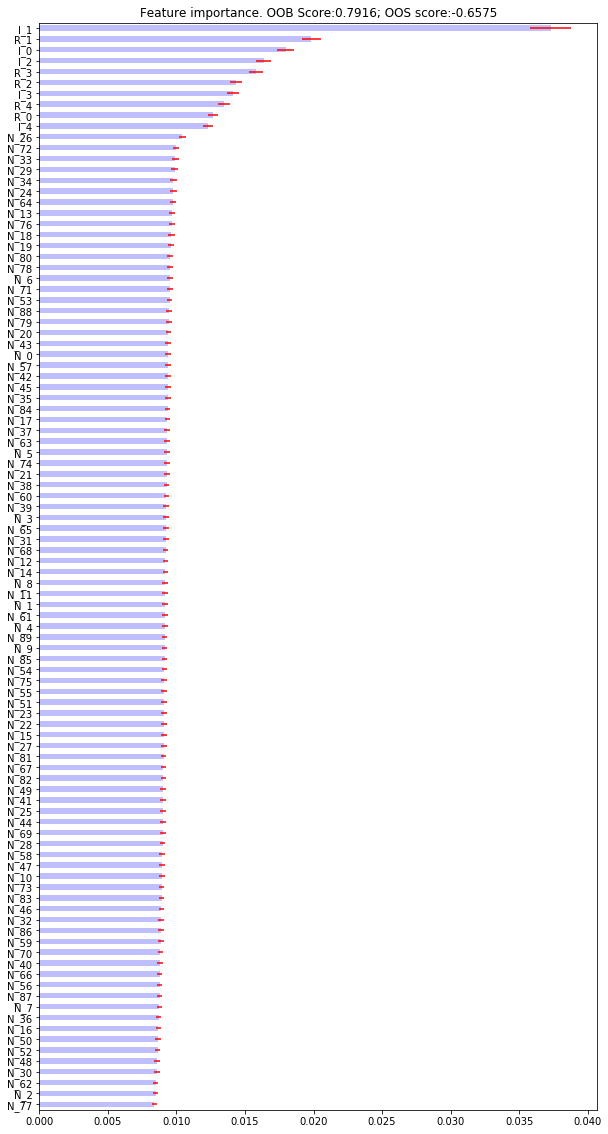

minimum importance: 0.01


In [5]:
mdi = mean_decrease_impurity(rf,xft)
plot_feature_importance(mdi,oob_score=rf.oob_score_, oos_score=oos_score)
print ('minimum importance:',1/len(xft))

### MDA

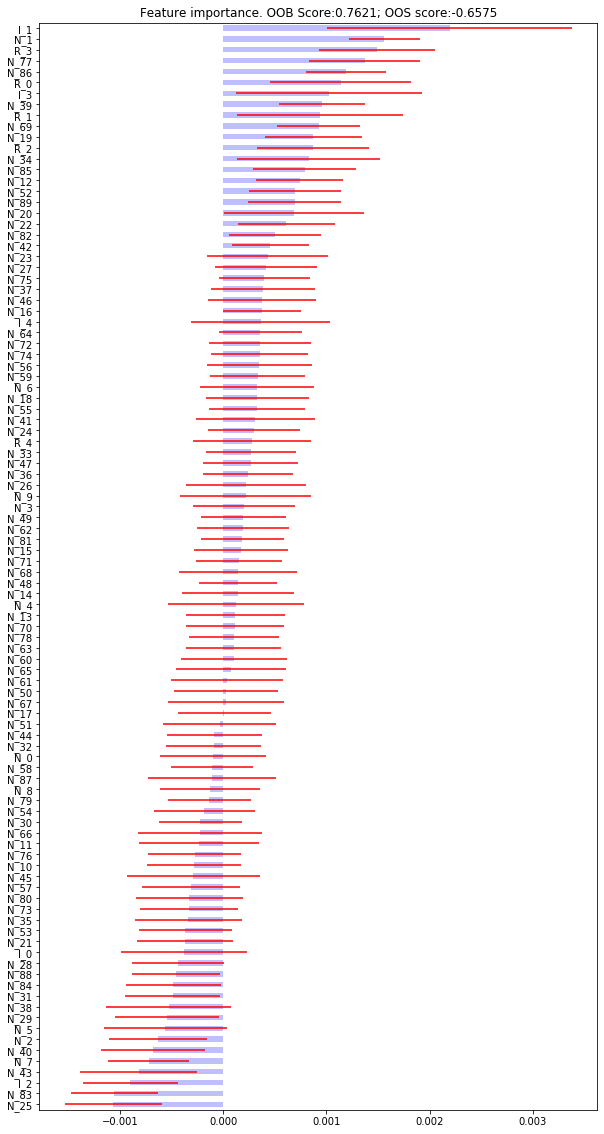

In [6]:
mda=mean_decrease_accuracy(rf,xdata,ydata,cv_gen,scoring=log_loss)

plot_feature_importance(mda,oob_score=rf.oob_score_, oos_score=oos_score)


### SFI

# PCA analysis

In [7]:
X=data[xft].copy()
Z=X.sub(X.mean(), axis=1).div(X.std(), axis=1)
ZtZ=pd.DataFrame(np.dot(Z.T,Z),index=X.columns,columns=X.columns)
eVal,eVec=np.linalg.eigh(ZtZ)
idx=eVal.argsort()[::-1]
eVal=eVal[idx]
th=0.95
eVal,eVec=_get_eigen_vector(ZtZ, th)

Xdot = pd.DataFrame(get_orthogonal_features(X,th), index=X.index).add_prefix("PCA_")
eVal=pd.Series(eVal.values,index=Xdot.columns)

print ('Eigen values:\n')
print (eVal)
print (Xdot.head())

Eigen values:

PCA_0     2220.139238
PCA_1     1314.354297
PCA_2     1119.620483
PCA_3      997.818981
PCA_4      919.736405
             ...     
PCA_78     273.955426
PCA_79     271.446665
PCA_80     264.028987
PCA_81     258.984765
PCA_82     255.089052
Length: 83, dtype: float64
      PCA_0     PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6  \
0 -2.622341 -2.305996  2.627868 -0.079404 -0.973808 -0.090371 -0.070109   
1 -2.976359 -1.519747 -1.565900  2.094220  1.881865  1.569343  0.107578   
2  3.179533 -3.038204 -3.435956 -0.489015 -0.220950  2.366306 -1.799182   
3 -1.718687 -0.206866  0.354781  0.472837 -0.374523 -1.741295  1.293020   
4 -3.228264 -0.636981 -1.309651  1.543608  0.788096 -0.754246 -0.978745   

      PCA_7     PCA_8     PCA_9  ...    PCA_73    PCA_74    PCA_75    PCA_76  \
0 -0.156480 -1.354061 -0.635641  ...  0.041587  0.426333  0.309849 -0.416885   
1 -0.394895  2.400781 -0.058385  ... -0.360082  0.757215  0.431052 -0.297932   
2 -0.028590 -0.843938 -0.

In [8]:
RANDOM_STATE=100
n_estimator=1000
maxsamples=1
rf=DecisionTreeClassifier(criterion='entropy',
                          max_features=1,#None,#1,
                          class_weight='balanced',
                          min_weight_fraction_leaf=0.0)

rf=BaggingClassifier(base_estimator=rf,
                     n_estimators=n_estimator,
                     max_features=1.,
                     #max_samples=maxsamples,
                     oob_score=True)

Y=np.sign(data[yft])
Xpca=Xdot.copy()

base = datetime.today()
numdays=len(Xpca)
t1 = [base - timedelta(days=x) for x in range(numdays,0,-1)]
t1=pd.DataFrame({'t1':t1})
t1=t1.set_index(t1.t1)
t1['t1']=t1['t1']
w=[1/len(cont) for x in range(numdays)]
w=pd.DataFrame({'w':w})
w=w.set_index(w.w)

rf.fit(Xpca,Y)
cv_gen=PurgedKFold(10,t1.t1)

### PCA MDI

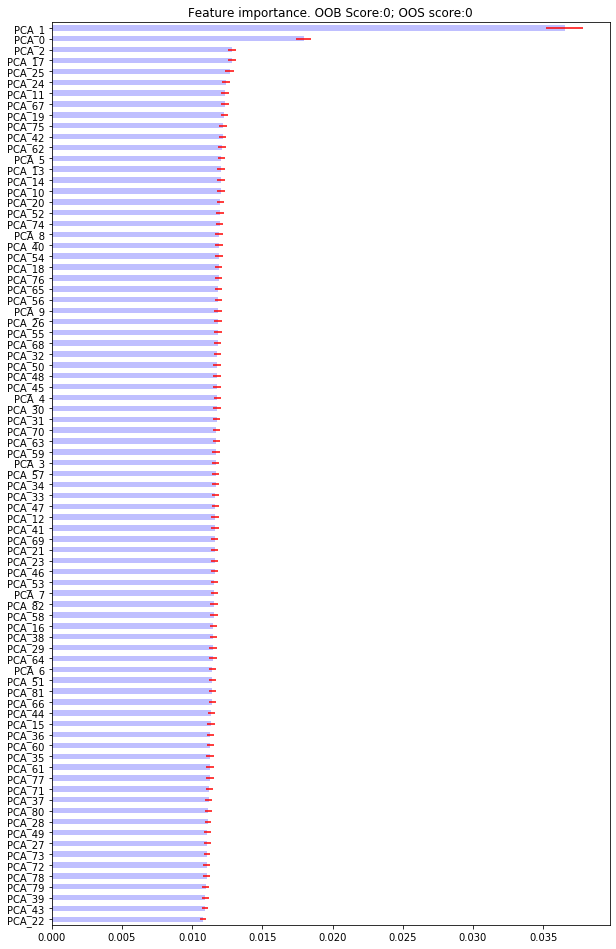

minimum importance: 0.01


{'Pearson': (0.009960364939895949, 0.420006586829978),
 'Spearman': SpearmanrResult(correlation=0.05011456643439227, pvalue=4.911065513324982e-05),
 'Kendall': KendalltauResult(correlation=0.03384439092605346, pvalue=4.401010450545914e-05),
 'Weighted_Kendall_Rank': WeightedTauResult(correlation=0.09698717048751836, pvalue=nan)}

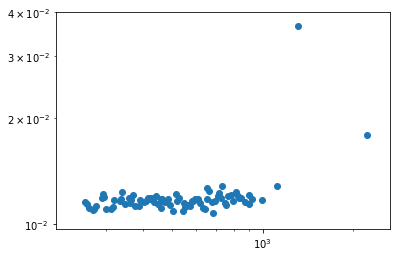

In [9]:
import matplotlib.pyplot as plt
imp = mean_decrease_impurity(rf,Xpca.columns)
plot_feature_importance(imp,0,0)
print ('minimum importance:',1/len(xft))
fig,aux=plt.subplots()
aux.scatter(eVal.loc[imp.index],imp['mean'])
aux.set_yscale('log')
aux.set_xscale('log')
aux.set_ylim([0.9*imp['mean'].values.min(),1.1*imp['mean'].values.max()])
aux.set_xlim([0.8*eVal.values.min(),1.2*eVal.values.max()])
feature_pca_analysis(Xpca,imp)

### PCA MDA

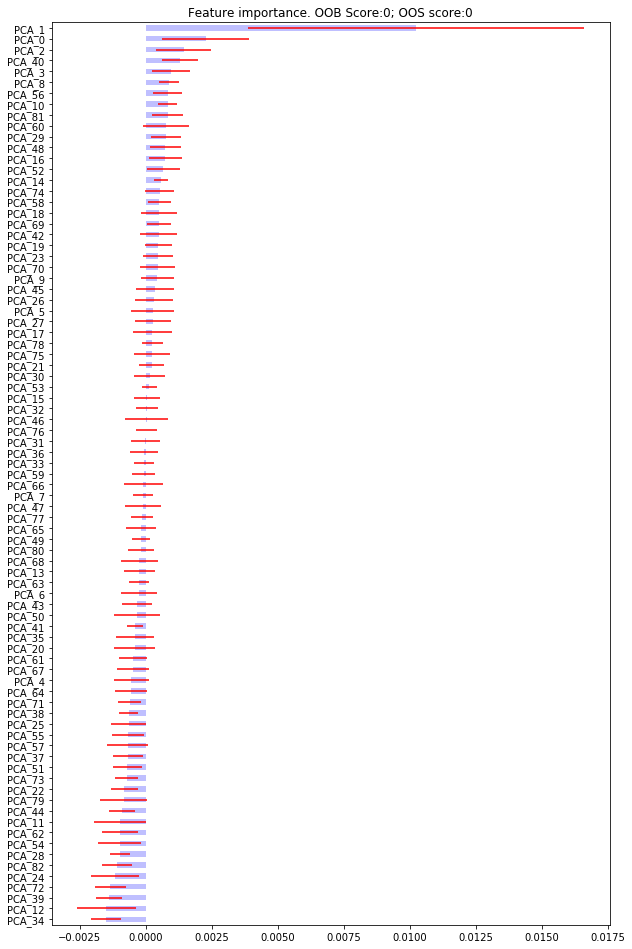

In [10]:
#MDA
imp=mean_decrease_accuracy(rf,Xpca,Y,cv_gen,scoring=log_loss)
plot_feature_importance(imp,0,0)


### PCA SFI

# Feature analysis

### Clustering

In [11]:
from mlfinlab.clustering.onc import get_onc_clusters
from mlfinlab.clustering.feature_clusters import get_feature_clusters
from sklearn.model_selection._split import KFold

clusters=get_feature_clusters(data[xft]
                              ,dependence_metric='linear'#'mutual_information'
                              #,distance_metric='angular'#None
                              #,linkage_method='single'#None
                              ,n_clusters=None)
clusters

No feature/s found with low silhouette score. All features belongs to its respective clusters


[['I_3', 'R_2', 'R_3', 'R_4'],
 ['I_0',
  'I_1',
  'I_2',
  'I_4',
  'N_0',
  'N_1',
  'N_2',
  'N_3',
  'N_4',
  'N_5',
  'N_6',
  'N_7',
  'N_8',
  'N_9',
  'N_10',
  'N_11',
  'N_12',
  'N_13',
  'N_14',
  'N_15',
  'N_16',
  'N_17',
  'N_18',
  'N_19',
  'N_20',
  'N_21',
  'N_22',
  'N_23',
  'N_24',
  'N_25',
  'N_26',
  'N_27',
  'N_28',
  'N_29',
  'N_30',
  'N_31',
  'N_32',
  'N_33',
  'N_34',
  'N_35',
  'N_36',
  'N_37',
  'N_38',
  'N_39',
  'N_40',
  'N_41',
  'N_42',
  'N_43',
  'N_44',
  'N_45',
  'N_46',
  'N_47',
  'N_48',
  'N_49',
  'N_50',
  'N_51',
  'N_52',
  'N_53',
  'N_54',
  'N_55',
  'N_56',
  'N_57',
  'N_58',
  'N_59',
  'N_60',
  'N_61',
  'N_62',
  'N_63',
  'N_64',
  'N_65',
  'N_66',
  'N_67',
  'N_68',
  'N_69',
  'N_70',
  'N_71',
  'N_72',
  'N_73',
  'N_74',
  'N_75',
  'N_76',
  'N_77',
  'N_78',
  'N_79',
  'N_80',
  'N_81',
  'N_82',
  'N_83',
  'N_84',
  'N_85',
  'N_86',
  'N_87',
  'N_88',
  'N_89',
  'R_0',
  'R_1']]

In [12]:
clf_base = DecisionTreeClassifier(criterion='entropy'
                                  ,max_features=1
                                  ,class_weight='balanced'
                                  ,min_weight_fraction_leaf=0)

clf = BaggingClassifier(base_estimator=clf_base
                        ,n_estimators=1000
                        ,max_features=1.
                        ,max_samples=1.
                        ,oob_score=True
                        ,n_jobs=-1)
X=data[xft]
y=np.sign(data[yft])
fit = clf.fit(X,y)
cvGen = KFold(n_splits=10)
oos_score = ml_cross_val_score(clf, X, y, cv_gen=cvGen, scoring=log_loss).mean()

##### MDI cluster

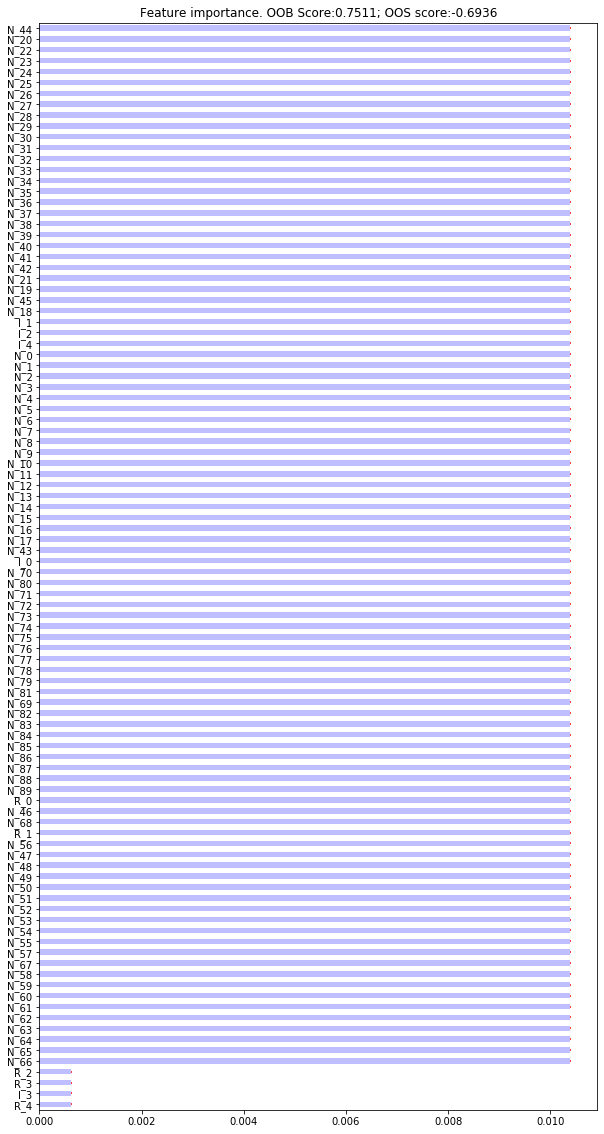

In [13]:
clustered_mdi_imp = mean_decrease_impurity(clf,X.columns,clustered_subsets=clusters)
plot_feature_importance(clustered_mdi_imp,oob_score=clf.oob_score_, oos_score=oos_score)

##### MDA cluster

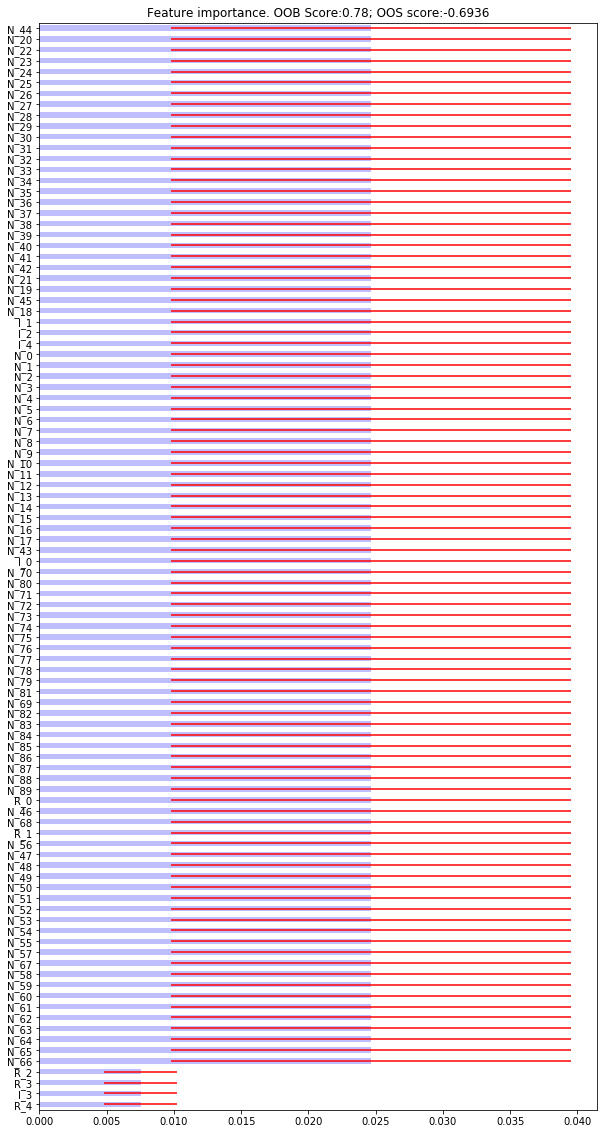

In [14]:
clustered_mda_imp = mean_decrease_accuracy(clf,X,y
                                           ,cv_gen=cvGen
                                           ,clustered_subsets=clusters
                                           ,random_state=0
                                           ,scoring=log_loss)
plot_feature_importance(clustered_mda_imp,oob_score=clf.oob_score_, oos_score=oos_score)

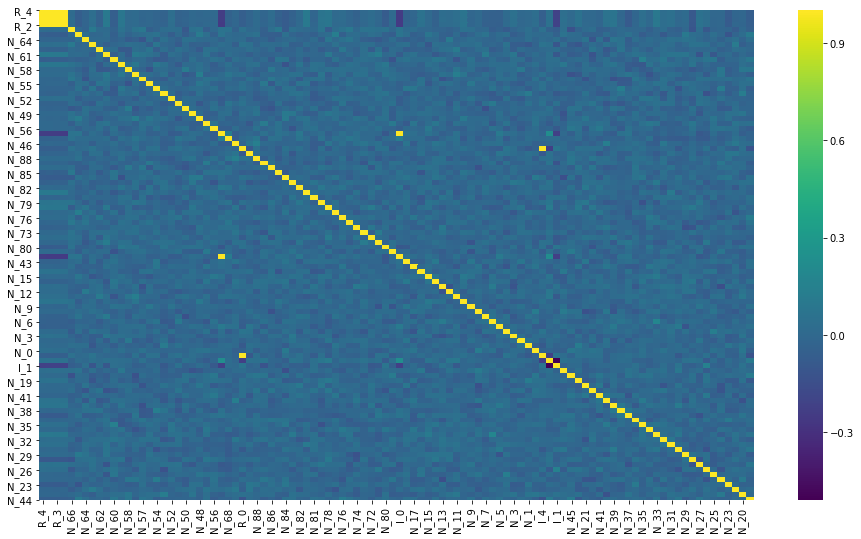

In [15]:
corr0,clstrs,silh = get_onc_clusters(X.corr())
plt.figure(figsize=(16,9))
sns.heatmap(corr0,cmap='viridis')